<h1> Solar Control Film</h1>

We are going to study the transmittance $T$ and reflectance $R$ for a three-layered system consisting of three thin films onto a glass substrate. The arrangement in question is: tin-oxide/silver/tin-oxide/glass. The arrangement is inmersed in air. The substrate is a thick film, i.e., non-coherent.

But before continuing, we need to load some packages and make some definitions for Python:

In [1]:
import numpy as np
import cmath 
import math
import matplotlib.pyplot as plt
from functools import reduce

wl= np.arange(300.0, 2510.0, 10.0) #<---Wavelengths in interval
l= len(wl)
j= complex(0,1)
T = np.array([None]*l)
R = np.array([None]*l)

Now, we are going to load the experimental refractive index of tin oxide, and silver:

In [2]:
wt,nt,kt = np.loadtxt('SnO_n_k.txt', unpack = True)
ws,ns,ks = np.loadtxt('Ag_n_k.txt', unpack = True)
TINOXIDE= np.array([complex(0.0,0.0)]*l)
SILVER= np.array([complex(0.0,0.0)]*l)
i = 0
while (i <= l-1):
	TINOXIDE[i]=complex(nt[i],kt[i])
	SILVER[i] = complex(ns[i],ks[i])
	i = i+1

We plot the refractive index of silver:

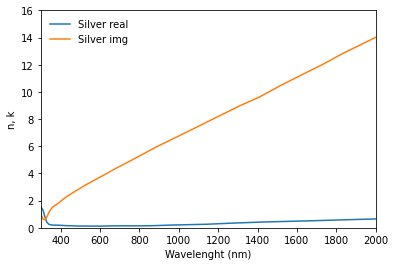

In [3]:
plt.plot(wl,ns,label='Silver real')
plt.plot(wl,ks,label='Silver img')
plt.ylim([0.0, 16])
plt.xlim([300.0, 2000])
plt.xlabel("Wavelenght (nm)")
plt.ylabel("n, k")
plt.legend(loc='best', fontsize= 10,frameon=False)
plt.show()

And of the refractive index of thin oxide:

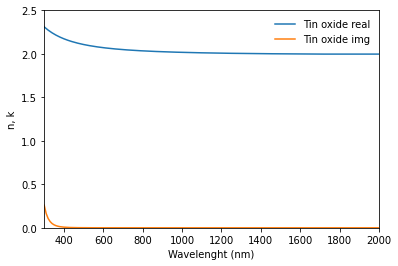

In [4]:
plt.plot(wl,nt,label='Tin oxide real')
plt.plot(wl,kt,label='Tin oxide img')
plt.ylim([0.0, 2.5])
plt.xlim([300.0, 2000])
plt.xlabel("Wavelenght (nm)")
plt.ylabel("n, k")
plt.legend(loc='best', fontsize= 10,frameon=False)
plt.show()

We assume that glass has a constant refractive index equal to 1.52 and that air has a refractive index of 1.00:

In [5]:
AIR = np.array([complex(1.0 , 0.0)] * l)
GLASS= np.array([complex(1.52, 0.0)]*l)

We define some functions that help us in calculating the different Fresnel coefficients: 

In [6]:
def fresnel_r(N_a,N_b):
	return (N_b-N_a)/(N_a+N_b)
	
def fresnel_t(N_a,N_b):
	return 2*N_a/(N_a+N_b)

We are going to calculate the transmittance following the **Matrix formalism** by B. Harbecke, App. Phys. B 39, 165-170 (1986). Accordingly, we define a function that calculates the **interface matrix**:

In [7]:
def interface_matrix (t_ab,r_ab):
	return np.matrix([[1.0/t_ab, r_ab/t_ab], [r_ab/t_ab, 1.0/t_ab]])

And the **transfer matrix**:

In [8]:
def transfer_matrix(N,d,lambda_i):		
	D1 =(cmath.exp(j*2*math.pi*N.real*d/lambda_i))*(cmath.exp(-2*math.pi*N.imag*d/lambda_i))
	return np.matrix([[D1**(-1), 0.0], [0.0, D1]])

It its time to define our layer stack:

In [9]:
N0 = AIR
N1 = TINOXIDE
d1 = 54.9
N2 = SILVER
d2= 26.0
N3 = TINOXIDE
d3= 30.0
N4= GLASS
d4= 1000000

Note that $d1$, $d2$, $d3$ and $d4$ are the **thicknesses in nm** of the layers tin-oxide/silver/tin-oxide/glass, respectively. You can modify those thicknesses if you want.

Use the functions we defined before to calculate the Fresnel coefficients:

In [10]:
r01 = fresnel_r(N0,N1)
t01 = fresnel_t(N0,N1)
r12 = fresnel_r(N1,N2)
t12 = fresnel_t(N1,N2)
r23 = fresnel_r(N2,N3)
t23 = fresnel_t(N2,N3)
r34 = fresnel_r(N3,N4)
t34 = fresnel_t(N3,N4)
t40 = fresnel_t(N4,N0)
t04 = fresnel_t(N0,N4)
r40 = fresnel_r(N4,N0)
r04 = fresnel_r(N0,N4)

And now do the product to obtain $T$ and $R$, according to the matrix formalism. 

In [11]:
i=0
while (i <= l-1):  

	M01 = interface_matrix(t01[i],r01[i])
	E1 = transfer_matrix(N1[i],d1,wl[i])
	#
	M12 = interface_matrix(t12[i],r12[i])
	E2 = transfer_matrix(N2[i],d2,wl[i])
	#
	M23 = interface_matrix(t23[i],r23[i])
	E3 = transfer_matrix(N3[i],d3,wl[i])
	#
	M34 = interface_matrix(t34[i],r34[i])
	

	A = reduce(np.dot, [M01,E1,M12,E2,M23,E3,M34])
	
	
	
	z = N4[i].real/N0[i].real
	zprime= N0[i]/N4[i]

	## ----- B. Harbecke App. Phys. B 39, 165-170 (1986) Eq. 9 and Eq. 11.
	tas = 1/A[0,0]
	ras = A[1,0]/A[0,0]
	tsa = (A[0,0]*A[1,1]-A[0,1]*A[1,0])/A[0,0]
	rsa =-A[0,1]/A[0,0]
	#--------
	
	#--------Now treating the problem as a thick film. Convert to intensities.
	T1 = z.real*abs(tas)**2
	T1prime =zprime.real*(abs(tsa)**2)
	R1 = abs(ras)**2
	R1prime=abs(rsa)**2
	
	R2 =abs(r40[i])**2
	T2 =N4[i].real/N0[i].real*(abs(t04[i])**2)
	
	# treating the problem as a thick film in which T1 and T1 prime come from the product of matrices A.
	T[i] = abs(T1*T2*cmath.exp(-2*math.pi*N4[i].imag*d4/wl[i])/(1-R1prime*R2*cmath.exp(-4*math.pi*N4[i].imag*d4/wl[i])))
	R[i] = abs(R1 + ((T1**2)*R2*cmath.exp(-4*math.pi*N4[i].imag*d4/wl[i]))/(1-R1prime*R2*cmath.exp(-4*math.pi*N4[i].imag*d4/wl[i])))
	i = i+1    

Now, we are going to compare our results with those of a real solar control glazing than can be found in the market. We now load the experimental $T$ and $R$ such commertial glazing:

In [12]:
wlT,Texp = np.loadtxt('Suncool_T.xy', unpack = True)
wlR,Rexp = np.loadtxt('Suncool_R.xy', unpack = True)

And plot the experimental curves together with our calculated results:

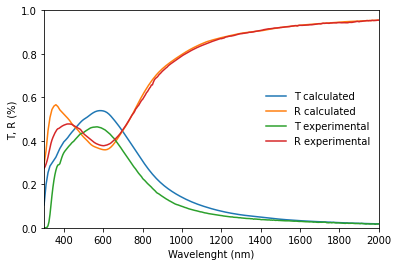

In [13]:
plt.plot(wl,T,label='T calculated')
plt.plot(wl,R,label='R calculated')
plt.plot(wlT,Texp,label='T experimental')
plt.plot(wlR,Rexp,label='R experimental')
plt.ylim([0.0, 1])
plt.xlim([300.0, 2000])
# #plt.plot(wl,R, label ='R')
plt.xlabel("Wavelenght (nm)")
plt.ylabel("T, R (%)")
plt.legend(loc='center right', fontsize= 10,frameon=False)
plt.show()